# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle
from tqdm import tqdm
import time
from datetime import datetime,date,timedelta

In [2]:
import shap
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import RepeatedStratifiedKFold, LeaveOneOut, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz, DecisionTreeClassifier


import joblib
import pickle
import xgboost as xgb
# from plot_learning import *
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve



from sklearn.feature_selection import SequentialFeatureSelector



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer

from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV

c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
def features_mean(X, delta, var, sufixo, var_group, date, type_window):
#   data= X.copy()
  #mean
  contadores_mean = (X.set_index(date).sort_index()
  .groupby(var_group)[var]
  .rolling(delta,closed= 'left', center=False)
  .mean()
  .fillna(0)
  ).reset_index().rename(columns={var:f'mean_{var}_{delta}{type_window}_{sufixo}'})

#   contadores_mean = contadores_mean.fillna(0)
  sub = var_group + [date]
  contadores_mean = contadores_mean.sort_values([date, f'mean_{var}_{delta}{type_window}_{sufixo}']).drop_duplicates(subset=sub, keep='first')
  return pd.merge(X, contadores_mean, on=sub, how='left', sort=False)



## Dados reais

In [5]:
df = pd.read_parquet('real_instances.parquet.gzip') 

In [6]:
df.shape

(14516197, 12)

In [7]:
df.head()

,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,,,,
2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,NaN,0.0,0.0
2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,NaN,0.0,0.0


### Análise inicial

In [8]:
df.id.nunique()

1013

In [9]:
df['label'].value_counts()

label
0    9903155
4    2462076
3     569152
5     552529
7     466338
1     312136
2     194233
6      56578
Name: count, dtype: int64

In [10]:
df['class'].value_counts()

class
0.0      10003293
4.0       2462076
3.0        569152
105.0      317565
107.0      283262
101.0       95658
102.0       65130
7.0         25870
2.0         16100
5.0         13031
6.0         12951
1.0         10417
106.0        6252
Name: count, dtype: int64

In [11]:
pd.crosstab(df['well'], df['label'])

label,0,1,2,3,4,5,6,7
well,,,,,,,,
WELL-00001,1652442,58468,0,17976,261457,0,0,73033
WELL-00002,3641159,24017,9121,0,807601,0,47869,0
WELL-00003,463543,0,35406,0,0,0,0,0
WELL-00004,85505,0,0,0,307674,0,8709,0
WELL-00005,979611,0,0,0,271525,0,0,0
WELL-00006,2058403,229651,0,0,0,0,0,305517
WELL-00007,14370,0,0,0,71651,0,0,0
WELL-00008,1008122,0,0,0,0,0,0,0
WELL-00009,0,0,6738,0,0,0,0,0


In [12]:
pd.crosstab(df['class'], df['label'])

label,0,1,2,3,4,5,6,7
class,,,,,,,,
0.0,9439612,195376,52017,0,0,127930,36319,152039
1.0,0,10417,0,0,0,0,0,0
2.0,0,0,16100,0,0,0,0,0
3.0,0,0,0,569152,0,0,0,0
4.0,0,0,0,0,2462076,0,0,0
5.0,0,0,0,0,0,13031,0,0
6.0,0,0,0,0,0,0,12951,0
7.0,0,0,0,0,0,0,0,25870
101.0,0,95658,0,0,0,0,0,0


In [13]:
df.drop_duplicates(subset=['id'], keep='last').groupby("label")["id"].count()

label
0    588
1      5
2     22
3     32
4    344
5     11
6      6
7      5
Name: id, dtype: int64

In [14]:
df.isnull().sum()/len(df)

label         0.000000
well          0.000000
id            0.000000
P-PDG         0.000580
P-TPT         0.008007
T-TPT         0.008007
P-MON-CKP     0.077959
T-JUS-CKP     0.113279
P-JUS-CKGL    0.071501
T-JUS-CKGL    1.000000
QGL           0.191125
class         0.043775
dtype: float64

In [15]:
df['target'] = 1
df.loc[(df['label']==0)&(df['class']==0), "target"] = 0

In [16]:
df.target.value_counts()

target
0    9439612
1    5076585
Name: count, dtype: int64

In [17]:
df.target.value_counts(normalize=True)

target
0    0.650281
1    0.349719
Name: proportion, dtype: float64

In [18]:
df2 = df.drop(['T-JUS-CKGL'], axis=1)
df2 = df2.dropna()

In [19]:
del df

In [20]:
df2.shape

(11108977, 12)

In [21]:
df2.target.value_counts(normalize=True)

target
0    0.663057
1    0.336943
Name: proportion, dtype: float64

In [22]:
df3 = df2.reset_index()
df3.head()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,class,target
0,2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,0.0,0
1,2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,0.0,0
2,2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,0.0,0
3,2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,0.0,0
4,2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,0.0,0


In [23]:
df3['well'].value_counts()

well
WELL-00002    4518972
WELL-00006    2588359
WELL-00001    2062763
WELL-00014     699734
WELL-00010     601704
WELL-00017     382288
WELL-00018      87162
WELL-00007      86021
WELL-00015      54811
WELL-00016      20465
WELL-00009       6698
Name: count, dtype: int64

### Features engineering

In [24]:
df3['timestamp'] = pd.to_datetime(df3['timestamp'], format="%Y-%m-%d %H:%M:%S.%f").dt.date

In [25]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

In [26]:
for i in VARS:
    df3[i] = df3[i].astype(float)

In [27]:
df3.head()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,class,target
0,2017-02-01,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,0.0,0
1,2017-02-01,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,0.0,0
2,2017-02-01,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,0.0,0
3,2017-02-01,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,0.0,0
4,2017-02-01,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,0.0,0


In [28]:
df3.tail()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,class,target
11108972,2019-04-03,7,WELL-00018,20190403023307,0.0,8489354.0,109.7213,1496222.0,73.38219,9706965.0,0.0,107.0,1
11108973,2019-04-03,7,WELL-00018,20190403023307,0.0,8489349.0,109.7212,1495828.0,73.38310,9706899.0,0.0,107.0,1
11108974,2019-04-03,7,WELL-00018,20190403023307,0.0,8489344.0,109.7210,1495433.0,73.38401,9706834.0,0.0,107.0,1
11108975,2019-04-03,7,WELL-00018,20190403023307,0.0,8489338.0,109.7209,1495039.0,73.38493,9706768.0,0.0,107.0,1
11108976,2019-04-03,7,WELL-00018,20190403023307,0.0,8489333.0,109.7207,1494645.0,73.38583,9706702.0,0.0,107.0,1


In [29]:
df3.well.unique()

array(['WELL-00001', 'WELL-00002', 'WELL-00006', 'WELL-00007',
       'WELL-00009', 'WELL-00010', 'WELL-00014', 'WELL-00015',
       'WELL-00016', 'WELL-00017', 'WELL-00018'], dtype=object)

In [30]:
df3.isnull().sum()

timestamp     0
label         0
well          0
id            0
P-PDG         0
P-TPT         0
T-TPT         0
P-MON-CKP     0
T-JUS-CKP     0
P-JUS-CKGL    0
QGL           0
class         0
target        0
dtype: int64

In [31]:
for v in VARS:
    ### variáveis para valor da transação por conta com janela em dias
    var_val=str(v)
    var_groupby=['well']
    sufixo='well'
    date='timestamp'
    type_window='D'

    # Variáveis para média das transações
    df3 = features_mean(X=df3, delta=7, var=var_val, sufixo=sufixo, var_group=var_groupby, date=date, type_window=type_window)
    df3 = features_mean(X=df3, delta=30, var=var_val, sufixo=sufixo, var_group=var_groupby, date=date, type_window=type_window)

In [32]:
df3.head()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,...,mean_T-TPT_7D_well,mean_T-TPT_30D_well,mean_P-MON-CKP_7D_well,mean_P-MON-CKP_30D_well,mean_T-JUS-CKP_7D_well,mean_T-JUS-CKP_30D_well,mean_P-JUS-CKGL_7D_well,mean_P-JUS-CKGL_30D_well,mean_QGL_7D_well,mean_QGL_30D_well
0,2017-02-01,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,...,117.611429,117.610303,1.006513e+06,1.149371e+06,79.067316,79.06716,-300917.8,-300917.8,0.0,0.0
1,2017-02-01,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,...,117.611429,117.610303,1.006513e+06,1.149371e+06,79.067316,79.06716,-300917.8,-300917.8,0.0,0.0
2,2017-02-01,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,...,117.611429,117.610303,1.006513e+06,1.149371e+06,79.067316,79.06716,-300917.8,-300917.8,0.0,0.0
3,2017-02-01,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,...,117.611429,117.610303,1.006513e+06,1.149371e+06,79.067316,79.06716,-300917.8,-300917.8,0.0,0.0
4,2017-02-01,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,...,117.611429,117.610303,1.006513e+06,1.149371e+06,79.067316,79.06716,-300917.8,-300917.8,0.0,0.0


In [33]:
df3.columns

Index(['timestamp', 'label', 'well', 'id', 'P-PDG', 'P-TPT', 'T-TPT',
       'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL', 'class', 'target',
       'mean_P-PDG_7D_well', 'mean_P-PDG_30D_well', 'mean_P-TPT_7D_well',
       'mean_P-TPT_30D_well', 'mean_T-TPT_7D_well', 'mean_T-TPT_30D_well',
       'mean_P-MON-CKP_7D_well', 'mean_P-MON-CKP_30D_well',
       'mean_T-JUS-CKP_7D_well', 'mean_T-JUS-CKP_30D_well',
       'mean_P-JUS-CKGL_7D_well', 'mean_P-JUS-CKGL_30D_well',
       'mean_QGL_7D_well', 'mean_QGL_30D_well'],
      dtype='object')

In [34]:
dataset = df3.drop(columns=['timestamp', 'label', 'well', 'id', 'class', 'target'])

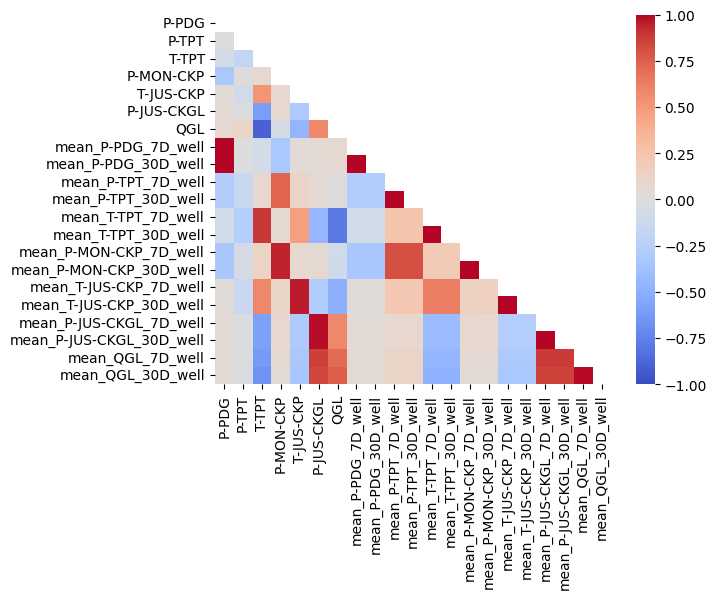

In [35]:
corrmat = np.triu(dataset.corr(method='pearson'))
g = sns.heatmap(dataset.corr(method='pearson'),cmap="coolwarm",annot=False, mask = corrmat, fmt=".2f", vmin=-1, vmax=1)

In [36]:
def remove_correlated_features(data, threshold):
    """
    Remove variáveis correlacionadas com base em um limiar.
    
    Parâmetros:
    - data: DataFrame Pandas contendo as variáveis.
    - threshold: O limiar de correlação a ser usado para remover variáveis.
    
    Retorna:
    - DataFrame Pandas contendo apenas as variáveis não correlacionadas.
    - Lista das variáveis removidas.
    """
    # Calcula a matriz de correlação
    corr_matrix = data.corr().abs()
    
    # Cria uma matriz booleana com True onde a correlação é maior que o limiar
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    
    # Obtém as colunas a serem removidas
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Remove as colunas
    data_filtered = data.drop(to_drop, axis=1)
    
    # Retorna as variáveis removidas e as que permaneceram
    removed_features = [column for column in data.columns if column in to_drop]
    remaining_features = [column for column in data.columns if column not in to_drop]
    
    return data_filtered, removed_features, remaining_features

In [44]:
threshold = 0.95  # Defina o limiar de correlação
dados, removed_features, remaining_features  = remove_correlated_features(dataset, threshold)

In [45]:
print("Quantidade de features removidas:", len(removed_features))
print("Quantidade de features selecionadas:", len(remaining_features))

Quantidade de features removidas: 10
Quantidade de features selecionadas: 11


In [46]:
dados.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,mean_P-TPT_7D_well,mean_T-TPT_7D_well,mean_P-MON-CKP_7D_well,mean_QGL_7D_well
0,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0
1,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0
2,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0
3,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0
4,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0


### Modelagem

In [48]:
dados.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,mean_P-TPT_7D_well,mean_T-TPT_7D_well,mean_P-MON-CKP_7D_well,mean_QGL_7D_well
0,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0
1,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0
2,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0
3,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0
4,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0


In [49]:
vars_select = dados.columns.tolist()

In [50]:
dados['target'] = df3['target']

In [51]:
dados.reset_index(drop=True, inplace=True)

In [52]:
dados.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,mean_P-TPT_7D_well,mean_T-TPT_7D_well,mean_P-MON-CKP_7D_well,mean_QGL_7D_well,target
0,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0,0
1,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0,0
2,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0,0
3,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0,0
4,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,9.855275e+06,117.611429,1.006513e+06,0.0,0


In [53]:
dados.dtypes

P-PDG                     float64
P-TPT                     float64
T-TPT                     float64
P-MON-CKP                 float64
T-JUS-CKP                 float64
P-JUS-CKGL                float64
QGL                       float64
mean_P-TPT_7D_well        float64
mean_T-TPT_7D_well        float64
mean_P-MON-CKP_7D_well    float64
mean_QGL_7D_well          float64
target                      int64
dtype: object

In [64]:
X_all = dados[vars_select]
y_all = dados['target']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.30 , stratify=y_all, random_state = 725)

print('Numero de observaçoes do treino:', len(X_train))
print('Numero de observaçoes da teste:',len(X_test))

Numero de observaçoes do treino: 7776283
Numero de observaçoes da teste: 3332694


In [65]:
train = X_train.copy()
train['target'] = pd.DataFrame(y_train)#.reset_index(drop=True)

test = X_test.copy()
test['target'] = pd.DataFrame(y_test)#.reset_index(drop=True) 

In [66]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,mean_P-TPT_7D_well,mean_T-TPT_7D_well,mean_P-MON-CKP_7D_well,mean_QGL_7D_well,target
8616816,0.0,16538200.0,118.0437,7066914.0,173.09610,4560234.0,0.0,1.645878e+07,117.965900,6.177805e+06,0.0,1
4792422,0.0,8518468.0,117.3785,1454243.0,76.24191,2325704.0,0.0,8.139633e+06,116.291100,9.757301e+05,0.0,0
7077495,44858050.0,21146550.0,116.5203,12225280.0,61.58792,1119992.0,0.0,2.114655e+07,116.481200,1.221827e+07,0.0,0
5237336,0.0,7959880.0,116.6375,1244927.0,72.54174,2319337.0,0.0,7.880082e+06,116.327971,9.366789e+05,0.0,0
8320236,38265830.0,13847800.0,117.1559,6002501.0,68.62134,3284403.0,0.0,1.370554e+07,116.293286,5.815453e+06,0.0,1


In [67]:
train.target.value_counts()

target
0    5156118
1    2620165
Name: count, dtype: int64

In [68]:
train.to_parquet('./data/train_feature_engineering.parquet.gzip',
              compression='gzip')

test.to_parquet('./data/test_feature_engineering.parquet.gzip',
              compression='gzip')

## Experimento

In [5]:
train = pd.read_parquet('./data/train_feature_engineering.parquet.gzip') 

test = pd.read_parquet('./data/test_feature_engineering.parquet.gzip')

In [6]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,mean_P-TPT_7D_well,mean_T-TPT_7D_well,mean_P-MON-CKP_7D_well,mean_QGL_7D_well,target
8616816,0.0,16538200.0,118.0437,7066914.0,173.09610,4560234.0,0.0,1.645878e+07,117.965900,6.177805e+06,0.0,1
4792422,0.0,8518468.0,117.3785,1454243.0,76.24191,2325704.0,0.0,8.139633e+06,116.291100,9.757301e+05,0.0,0
7077495,44858050.0,21146550.0,116.5203,12225280.0,61.58792,1119992.0,0.0,2.114655e+07,116.481200,1.221827e+07,0.0,0
5237336,0.0,7959880.0,116.6375,1244927.0,72.54174,2319337.0,0.0,7.880082e+06,116.327971,9.366789e+05,0.0,0
8320236,38265830.0,13847800.0,117.1559,6002501.0,68.62134,3284403.0,0.0,1.370554e+07,116.293286,5.815453e+06,0.0,1


In [7]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL', 'mean_P-TPT_7D_well', 'mean_T-TPT_7D_well', 'mean_P-MON-CKP_7D_well', 'mean_QGL_7D_well']

X_train = train[VARS]
y_train = train.target

In [8]:
X_test = test[VARS]
y_test = test.target

In [9]:
X_train.describe()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,mean_P-TPT_7D_well,mean_T-TPT_7D_well,mean_P-MON-CKP_7D_well,mean_QGL_7D_well
count,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06
mean,-3.773320e+40,2.789141e+07,1.082520e+02,4.574691e+06,7.467662e+01,1.134351e+08,1.669527e-01,1.263508e+07,1.048262e+02,3.912419e+06,7.555598e-02
std,2.076193e+41,2.054327e+08,2.157077e+01,3.595426e+06,3.278656e+01,4.258422e+08,4.544998e-01,5.159311e+06,2.860055e+01,3.660637e+06,2.854559e-01
min,-1.180116e+42,4.488654e+06,7.236000e+00,7.534167e+05,-2.020000e+00,-4.976717e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,8.529773e+06,1.164868e+02,1.682391e+06,6.174434e+01,2.316301e+06,0.000000e+00,7.999946e+06,1.159359e+02,1.165978e+06,0.000000e+00
50%,0.000000e+00,1.412337e+07,1.170522e+02,2.493314e+06,7.322810e+01,2.335133e+06,0.000000e+00,1.334799e+07,1.164435e+02,2.044719e+06,0.000000e+00
75%,2.383019e+07,1.664394e+07,1.178640e+02,6.179924e+06,7.758095e+01,4.426037e+06,0.000000e+00,1.645878e+07,1.173802e+02,5.931414e+06,0.000000e+00
max,4.485805e+07,2.941990e+09,1.196061e+02,1.284910e+07,1.730961e+02,2.027865e+09,4.146514e+00,2.118654e+07,1.188640e+02,1.227121e+07,1.715941e+00


In [10]:
len(y_test)

3332694

Padronização dos dados

In [11]:
scale = StandardScaler() 
# scale = MinMaxScaler()



X_train = scale.fit_transform(X_train)

X_test = scale.transform(X_test)


X_train = pd.DataFrame(X_train, columns=VARS)
X_test = pd.DataFrame(X_test, columns=VARS)

In [12]:
with open('./models/scale_std_feature_engineering.pkl', 'wb') as file: 
    pickle.dump(scale, file)

In [80]:
# file_std = "./models/scale_feature_engineering.pkl"

# scale = joblib.load(file_std)

In [81]:
# X_train = scale.transform(X_train)

# X_test = scale.transform(X_test)


# X_train = pd.DataFrame(X_train, columns=VARS)
# X_test = pd.DataFrame(X_test, columns=VARS)

In [13]:
train = X_train.copy()
train['target'] = pd.DataFrame(y_train).reset_index(drop=True)

test = X_test.copy()
test['target'] = pd.DataFrame(y_test).reset_index(drop=True) 

In [14]:
del X_train
del X_test

In [15]:
for i in VARS:
    train[i] = train[i].astype(float)

for i in VARS:
    test[i] = test[i].astype(float)

In [16]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,mean_P-TPT_7D_well,mean_T-TPT_7D_well,mean_P-MON-CKP_7D_well,mean_QGL_7D_well,target
0,0.181742,-0.055265,0.453935,0.693165,3.001824,-0.255670,-0.367333,0.741127,0.459421,0.618850,-0.264685,1
1,0.181742,-0.094303,0.423097,-0.867894,0.047742,-0.260917,-0.367333,-0.871327,0.400863,-0.802234,-0.264685,0
2,0.181742,-0.032832,0.383311,2.127867,-0.399209,-0.263748,-0.367333,1.649731,0.407510,2.268965,-0.264685,0
3,0.181742,-0.097022,0.388745,-0.926111,-0.065114,-0.260932,-0.367333,-0.921634,0.402152,-0.812902,-0.264685,0
4,0.181742,-0.068361,0.412777,0.397118,-0.184688,-0.258666,-0.367333,0.207481,0.400939,0.519864,-0.264685,1


### Random Forest

In [17]:
RF = RandomForestClassifier(random_state=23, n_jobs=-1)

cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

RF_search_space = {"bootstrap": ([True]), 
        "criterion": (["entropy"]),
        "max_depth": (8, 12),
        "max_features": (['log2']), 
        "min_samples_leaf": ([50]),
        "min_samples_split": ([100]),
        "n_estimators": (100, 200), 
        "class_weight": (['balanced'])
    }

In [18]:
RF_search = GridSearchCV(estimator=RF, param_grid=RF_search_space, scoring='roc_auc', cv=cv)


start_time = time.time()
RF_search.fit(train[VARS], train.target) 
end_time = time.time()
execution_time = end_time - start_time
print(f'Tempo de execução do modelo: {execution_time:.2f} segundos')
print("roc-auc")
print(RF_search.best_score_)
RF_best = RF_search.best_estimator_
print(RF_search.best_estimator_)
print(RF_search.best_params_)

Tempo de execução do modelo: 3597.59 segundos
roc-auc
0.9999998668604523
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features='log2', min_samples_leaf=50,
                       min_samples_split=100, n_estimators=200, n_jobs=-1,
                       random_state=23)
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 200}


In [19]:
y_pred_train = RF_best.predict(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.99958   0.99999   0.99979   5156118
           1    0.99998   0.99917   0.99958   2620165

    accuracy                        0.99972   7776283
   macro avg    0.99978   0.99958   0.99968   7776283
weighted avg    0.99972   0.99972   0.99972   7776283

Specificity: 0.9999920482812845
Gini:  0.9991638561636127
ROC AUC::  0.9995819280818063


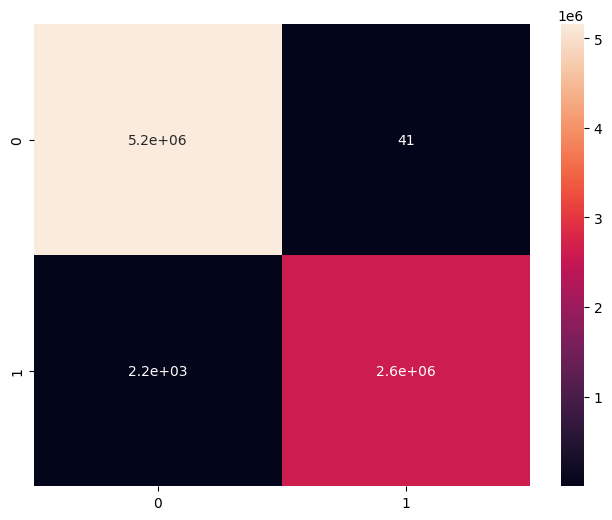

In [20]:
metrics(train.target, y_pred_train)

In [21]:
y_pred_test = RF_best.predict(test[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.99958   0.99999   0.99979   2209766
           1    0.99998   0.99918   0.99958   1122928

    accuracy                        0.99972   3332694
   macro avg    0.99978   0.99959   0.99969   3332694
weighted avg    0.99972   0.99972   0.99972   3332694

Specificity: 0.9999914018045349
Gini:  0.9991738961407703
ROC AUC::  0.9995869480703852


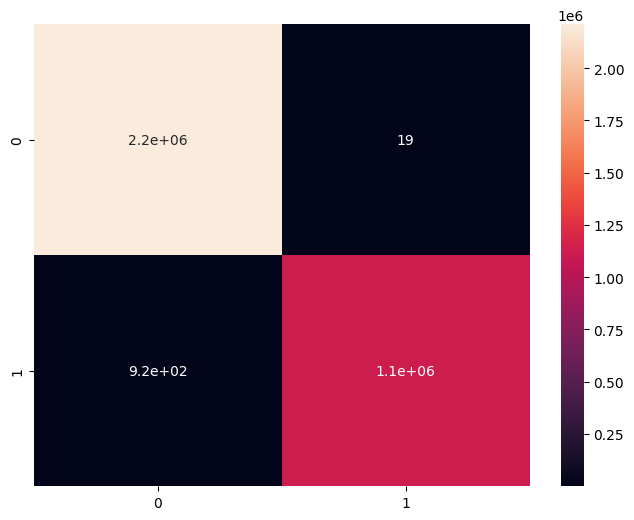

In [22]:
metrics(test.target, y_pred_test)

In [23]:
with open('./models/RF_std_feature_engineering.pkl', 'wb') as file: 
    pickle.dump(RF_best, file)

### LGBM

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [24]:
LGBM = LGBMClassifier(random_state=32, n_jobs = -1)

cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

LGBM_search_space = {
        'learning_rate' : (0.001, 0.05) , 
        'n_estimators': (100, 200),
        'boosting_type': (['goss']),
        'objective': (['binary']),
        "num_leaves": (16, 32),
        "max_depth": (6, 12), 
        "min_child_samples": (100, 200), 
        "class_weight": (["balanced"])
         }

In [25]:
LGBM_search = GridSearchCV(estimator=LGBM, param_grid=LGBM_search_space, scoring='roc_auc', cv=cv)


start_time = time.time()
LGBM_search.fit(train[VARS], train.target) 
end_time = time.time()
execution_time = end_time - start_time
print(f'Tempo de execução do modelo: {execution_time:.2f} segundos')
print("roc-auc")
print(LGBM_search.best_score_)
LGBM_best = LGBM_search.best_estimator_
print(LGBM_search.best_estimator_)
print(LGBM_search.best_params_)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 2096132, number of negative: 4124894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.227513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 6221026, number of used features: 11
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training fr

In [26]:
y_pred_train = LGBM_best.predict(train[VARS])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Classification Report: 
               precision    recall  f1-score   support

           0    0.99976   0.99969   0.99973   5156118
           1    0.99940   0.99952   0.99946   2620165

    accuracy                        0.99964   7776283
   macro avg    0.99958   0.99961   0.99959   7776283
weighted avg    0.99964   0.99964   0.99964   7776283

Specificity: 0.9996949255234268
Gini:  0.999218619641927
ROC AUC::  0.9996093098209635


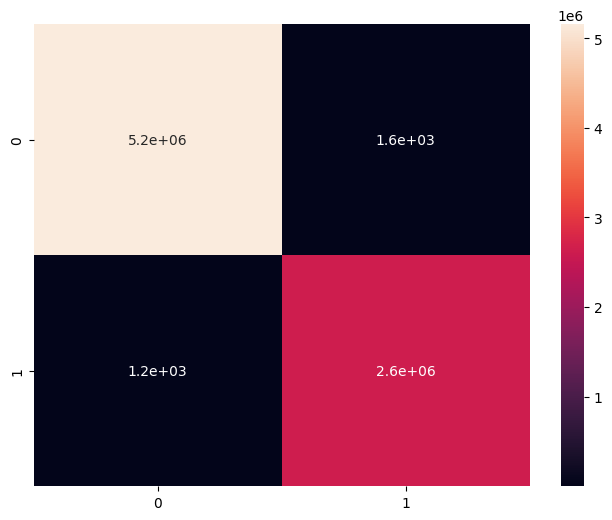

In [27]:
metrics(train.target, y_pred_train)

In [28]:
y_pred_test = LGBM_best.predict(test[VARS])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Classification Report: 
               precision    recall  f1-score   support

           0    0.99972   0.99970   0.99971   2209766
           1    0.99941   0.99945   0.99943   1122928

    accuracy                        0.99962   3332694
   macro avg    0.99957   0.99957   0.99957   3332694
weighted avg    0.99962   0.99962   0.99962   3332694

Specificity: 0.9997008733051372
Gini:  0.9991496358259757
ROC AUC::  0.9995748179129879


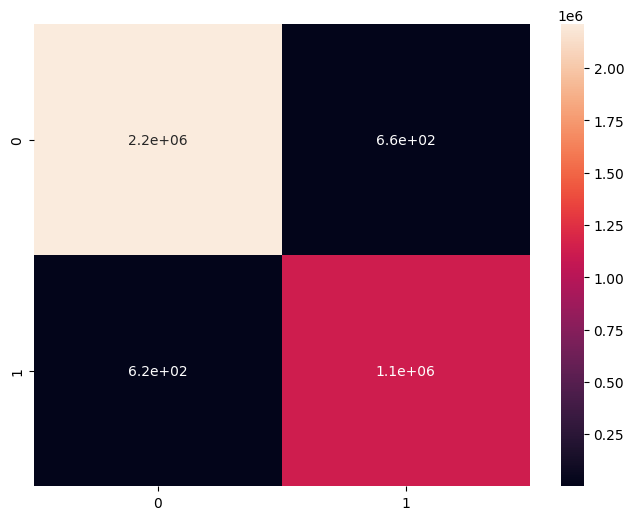

In [29]:
metrics(test.target, y_pred_test)

In [30]:
with open('./models/LGBM_std_feature_engineering.pkl', 'wb') as file: 
    pickle.dump(LGBM_best, file)

### XGBoost

https://xgboost.readthedocs.io/en/stable/parameter.html

In [31]:
XGB = xgb.XGBClassifier(random_state=33, n_jobs=-1)
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)


XGB_search_space = {
        "booster": (["gbtree"]),
        'learning_rate' : (0.001, 0.05) , 
        'n_estimators': (50, 200),
        'objective': (["binary:logistic"]),
        "max_depth": (6, 12), 
        "min_child_weight": (150, 200), 
        "reg_alpha": (0.001, 0.5)
         }

In [32]:
XGB_search = GridSearchCV(estimator=XGB, param_grid=XGB_search_space, scoring='roc_auc', cv=cv)


inicio = time.time()
XGB_search.fit(train[VARS], train.target) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("roc-auc")
print(XGB_search.best_score_)
XGB_best = XGB_search.best_estimator_
print(XGB_search.best_estimator_)
print(XGB_search.best_params_)

time train
2225.497428417206
roc-auc
0.9999996054749958
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=150, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=33, ...)
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 150, 'n_estimators': 200, 'objective': 'binary:logistic', 'reg_alpha': 0.5}


In [33]:
y_pred_train = XGB_best.predict(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.99968   0.99984   0.99976   5156118
           1    0.99969   0.99937   0.99953   2620165

    accuracy                        0.99968   7776283
   macro avg    0.99968   0.99961   0.99965   7776283
weighted avg    0.99968   0.99968   0.99968   7776283

Specificity: 0.9998415474587664
Gini:  0.9992133427464678
ROC AUC::  0.9996066713732339


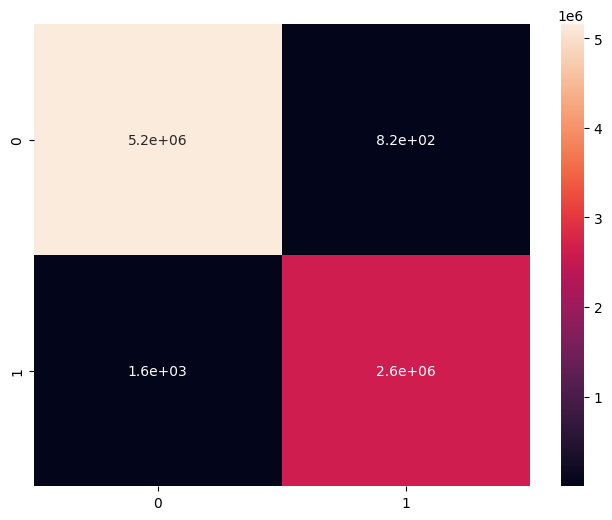

In [34]:
metrics(train.target, y_pred_train)

In [35]:
y_pred_test = XGB_best.predict(test[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.99967   0.99983   0.99975   2209766
           1    0.99967   0.99934   0.99951   1122928

    accuracy                        0.99967   3332694
   macro avg    0.99967   0.99959   0.99963   3332694
weighted avg    0.99967   0.99967   0.99967   3332694

Specificity: 0.9998330139933369
Gini:  0.999176694086807
ROC AUC::  0.9995883470434035


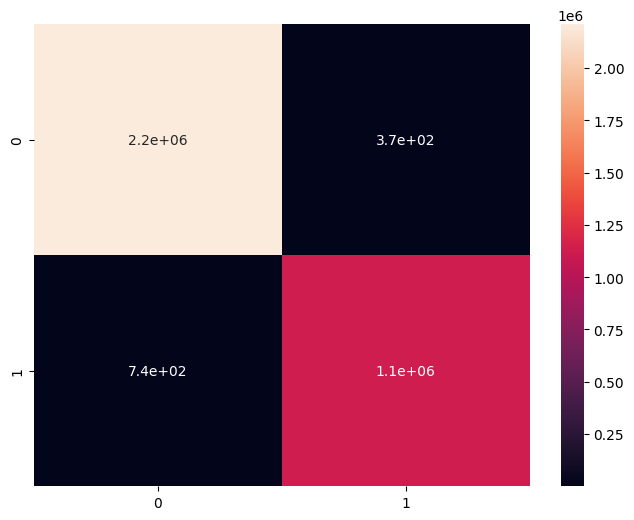

In [36]:
metrics(test.target, y_pred_test)

In [37]:
with open('./models/XGB_std_feature_engineering.pkl', 'wb') as file: 
    pickle.dump(XGB_best, file)

### Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [38]:
LR = LogisticRegression(random_state=25)
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

LR_search_space = {
    'penalty': (['l1','l2']),
    'C': (0.01, 1),
    'fit_intercept': ([True, False]), 
    'class_weight': (['balanced'])
}

In [39]:
LR_search = GridSearchCV(estimator=LR, param_grid=LR_search_space, scoring='roc_auc', cv=cv)

inicio = time.time()
LR_search.fit(train[VARS], train.target) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(LR_search.best_score_)
LR_best = LR_search.best_estimator_
print(LR_search.best_estimator_)
print(LR_search.best_params_)

c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
4 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\sklearn\linear_model\_logistic.py", lin

time train
118.6600251197815
Acc
0.9505418645627561
LogisticRegression(C=1, class_weight='balanced', fit_intercept=False,
                   random_state=25)
{'C': 1, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2'}


In [40]:
y_pred_train = LR_best.predict(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.92621   0.99129   0.95765   5156118
           1    0.98012   0.84460   0.90733   2620165

    accuracy                        0.94187   7776283
   macro avg    0.95317   0.91795   0.93249   7776283
weighted avg    0.94438   0.94187   0.94069   7776283

Specificity: 0.9912940316726654
Gini:  0.8358923680369783
ROC AUC::  0.9179461840184892


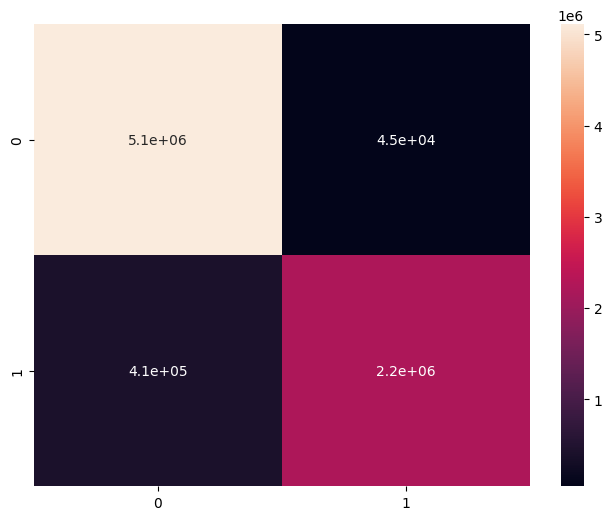

In [41]:
metrics(train.target, y_pred_train)

In [42]:
y_pred_test = LR_best.predict(test[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.92582   0.99118   0.95739   2209766
           1    0.97984   0.84372   0.90670   1122928

    accuracy                        0.94149   3332694
   macro avg    0.95283   0.91745   0.93204   3332694
weighted avg    0.94402   0.94149   0.94031   3332694

Specificity: 0.9911791565260756
Gini:  0.8348966522159149
ROC AUC::  0.9174483261079575


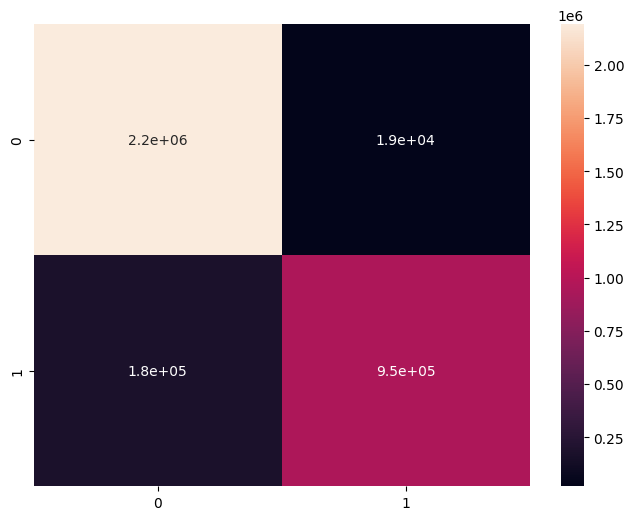

In [43]:
metrics(test.target, y_pred_test)

In [44]:
with open('./models/LR_std_feature_engineering.pkl', 'wb') as file: 
    pickle.dump(LR_best, file)

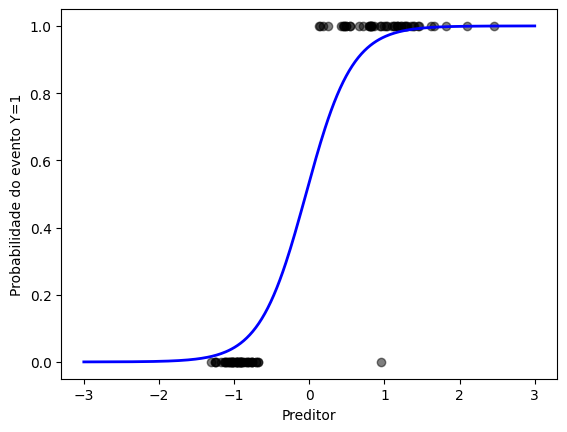

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Gerar dados de exemplo
X, y = make_classification(n_samples=100, n_features=1, n_informative=1, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=42)

# Criar e treinar o modelo de regressão logística
model = LogisticRegression()
model.fit(X, y)

# Plotar os pontos de dados
plt.scatter(X, y, color='black',  alpha=0.5)

# Plotar a curva de decisão da regressão logística
X_test = np.linspace(-3, 3, 300).reshape(-1, 1)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
plt.plot(X_test, y_prob, color='blue', linewidth=2)

# Configurar rótulos e título
plt.xlabel('Preditor')
plt.ylabel('Probabilidade do evento Y=1')
# plt.title('Logistic Regression')

# Exibir o gráfico
plt.show()